<a href="https://colab.research.google.com/github/cesphamm/procesamiento_lenguaje_natural/blob/main/Desafio_3_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">

# Procesamiento de Lenguaje Natural
## Desafío 3: Modelo de Lenguaje con Tokenización por Caracteres

**Autor:** Carlos Espinola  
**Fecha:** Diciembre 2025

### Versión: TensorFlow/Keras

---
## Objetivos del Desafío

### Consigna
1. **Seleccionar un corpus de texto** sobre el cual entrenar el modelo de lenguaje
2. **Pre-procesamiento**: tokenizar el corpus, estructurar el dataset y separar datos de entrenamiento y validación
3. **Proponer arquitecturas RNN**: implementar modelos basados en unidades recurrentes (SimpleRNN, LSTM, GRU)
4. **Generación de secuencias** con diferentes estrategias:
   - Greedy Search
   - Beam Search Determinístico
   - Beam Search Estocástico (analizando el efecto de la temperatura)

### Sugerencias
- Guiarse por el descenso de la **perplejidad** en validación para finalizar el entrenamiento
- Explorar: SimpleRNN (celda de Elman), LSTM y GRU
- `RMSprop` es el optimizador recomendado para buena convergencia

In [1]:
# =============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import urllib.request
import bs4 as bs

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"🔧 TensorFlow version: {tf.__version__}")
print(f"🔧 Keras version: {keras.__version__}")

🔧 TensorFlow version: 2.19.0
🔧 Keras version: 3.10.0


In [2]:
# Configuración de GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n🎮 GPU detectada: {len(gpus)} dispositivo(s)")
    for gpu in gpus:
        print(f"   • {gpu.name}")

    # Habilitar crecimiento dinámico de memoria
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    # Habilitar mixed precision para acelerar entrenamiento
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("\n⚡ Mixed Precision (float16) ACTIVADO")
    print("✅ Optimizaciones de GPU activadas")
else:
    print("\n⚠️ No se detectó GPU. El entrenamiento será más lento en CPU.")
    print("   Si tienes GPU, verifica la instalación de CUDA y TensorFlow-GPU.")


🎮 GPU detectada: 1 dispositivo(s)
   • /physical_device:GPU:0

⚡ Mixed Precision (float16) ACTIVADO
✅ Optimizaciones de GPU activadas


---
## 2. Selección y Descarga del Corpus

In [3]:
# Descargar el libro desde textos.info
url = 'https://www.textos.info/homero/odisea/ebook'
raw_html = urllib.request.urlopen(url)
raw_html = raw_html.read()

# Parsear el HTML con BeautifulSoup
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Extraer todos los párrafos
article_paragraphs = article_html.find_all('p')

# Concatenar el texto de todos los párrafos
corpus = ''
for para in article_paragraphs:
    corpus += para.text + ' '

# Convertir a minúsculas para normalizar
corpus = corpus.lower()

print(f"📚 Longitud total del corpus: {len(corpus):,} caracteres")
print(f"\n📖 Primeros 500 caracteres del corpus:")
print("-" * 50)
print(corpus[:500])

📚 Longitud total del corpus: 681,633 caracteres

📖 Primeros 500 caracteres del corpus:
--------------------------------------------------
 háblame, musa, de aquel varón de multiforme ingenio que, después de 
destruir la sacra ciudad de troya, anduvo peregrinando larguísimo 
tiempo, vio las poblaciones y conoció las costumbres de muchos hombres y
 padeció en su ánimo gran número de trabajos en su navegación por el 
ponto, en cuanto procuraba salvar su vida y la vuelta de sus compañeros a
 la patria. mas ni aun así pudo librarlos, como deseaba, y todos 
perecieron por sus propias locuras. ¡insensatos! comiéronse las vacas de
 helios


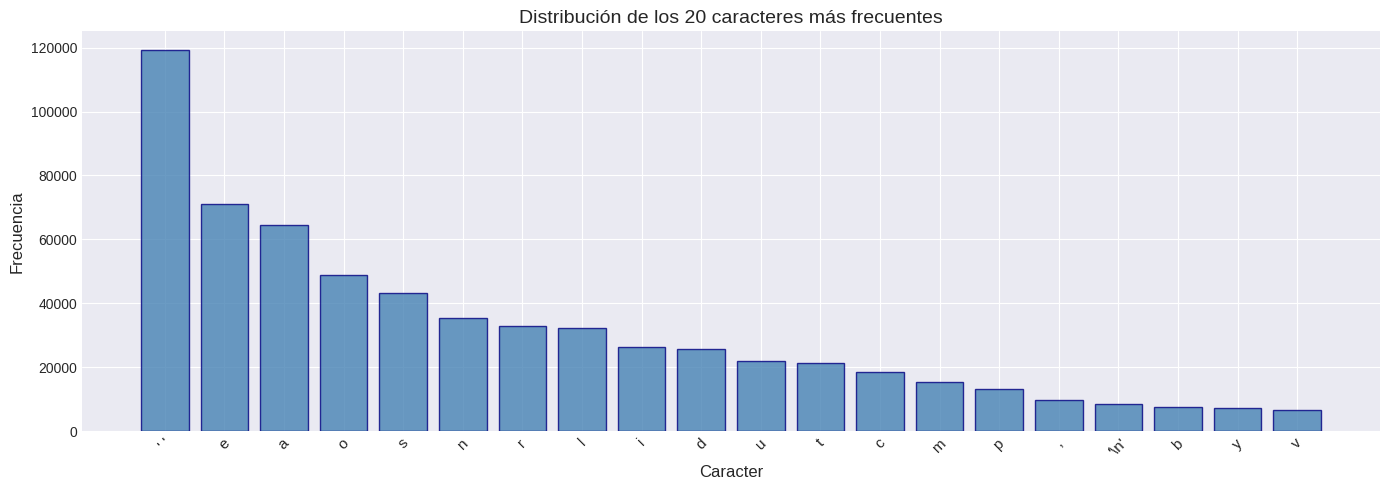

In [4]:
# Análisis de distribución de caracteres en el corpus
char_counts = Counter(corpus)
most_common = char_counts.most_common(20)

fig, ax = plt.subplots(figsize=(14, 5))
chars, counts = zip(*most_common)
chars_display = [repr(c) if c in [' ', '\n', '\t'] else c for c in chars]
bars = ax.bar(chars_display, counts, color='steelblue', edgecolor='navy', alpha=0.8)
ax.set_xlabel('Caracter', fontsize=12)
ax.set_ylabel('Frecuencia', fontsize=12)
ax.set_title('Distribución de los 20 caracteres más frecuentes', fontsize=14)
plt.xticks(rotation=45, fontsize=11)
plt.tight_layout()
plt.show()

---
## 3. Tokenización por Caracteres

In [5]:
# Crear vocabulario de caracteres únicos
chars_vocab = sorted(set(corpus))
vocab_size = len(chars_vocab)

print(f"📝 Tamaño del vocabulario: {vocab_size} caracteres únicos")
print(f"\n🔤 Caracteres en el vocabulario:")
print(chars_vocab)

📝 Tamaño del vocabulario: 58 caracteres únicos

🔤 Caracteres en el vocabulario:
['\t', '\n', ' ', '!', '"', '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', '¡', '¿', 'á', 'é', 'í', 'ñ', 'ó', 'ú', 'ü', '—']


In [6]:
# Crear diccionarios de mapeo
char2idx = {ch: idx for idx, ch in enumerate(chars_vocab)}
idx2char = {idx: ch for ch, idx in char2idx.items()}

print("🔗 Ejemplos de mapeo char2idx:")
for ch in ['a', 'e', 'i', 'o', 'u', ' ', '.']:
    if ch in char2idx:
        print(f"  '{ch}' -> {char2idx[ch]}")

🔗 Ejemplos de mapeo char2idx:
  'a' -> 24
  'e' -> 28
  'i' -> 32
  'o' -> 37
  'u' -> 43
  ' ' -> 2
  '.' -> 9


In [7]:
# Tokenizar el corpus completo
tokenized_corpus = np.array([char2idx[ch] for ch in corpus], dtype=np.int32)

print(f"📊 Corpus tokenizado - shape: {tokenized_corpus.shape}")
print(f"\n🔢 Primeros 50 tokens:")
print(tokenized_corpus[:50])

📊 Corpus tokenizado - shape: (681633,)

🔢 Primeros 50 tokens:
[ 2 31 50 25 34 24 35 28  7  2 35 43 41 24  7  2 27 28  2 24 39 43 28 34
  2 44 24 40 54 36  2 27 28  2 35 43 34 42 32 29 37 40 35 28  2 32 36 30
 28 36]


---
## 4. Estructuración del Dataset

In [8]:
# Definir tamaño de contexto
MAX_CONTEXT_SIZE = 100

print(f"⚙️ Tamaño de contexto: {MAX_CONTEXT_SIZE} caracteres")

⚙️ Tamaño de contexto: 100 caracteres


In [9]:
# División en entrenamiento y validación
p_val = 0.1
split_idx = int(len(tokenized_corpus) * (1 - p_val))

train_corpus = tokenized_corpus[:split_idx]
val_corpus = tokenized_corpus[split_idx:]

print(f"📊 División del corpus:")
print(f"  • Entrenamiento: {len(train_corpus):,} caracteres ({len(train_corpus)/len(tokenized_corpus)*100:.1f}%)")
print(f"  • Validación: {len(val_corpus):,} caracteres ({len(val_corpus)/len(tokenized_corpus)*100:.1f}%)")

📊 División del corpus:
  • Entrenamiento: 613,469 caracteres (90.0%)
  • Validación: 68,164 caracteres (10.0%)


In [10]:
def create_sequences(corpus_data, seq_length):
    """Crea secuencias de entrada y target para entrenamiento many-to-many."""
    n_sequences = len(corpus_data) - seq_length
    X = np.zeros((n_sequences, seq_length), dtype=np.int32)
    y = np.zeros((n_sequences, seq_length), dtype=np.int32)
    for i in range(n_sequences):
        X[i] = corpus_data[i:i + seq_length]
        y[i] = corpus_data[i + 1:i + seq_length + 1]
    return X, y

X_train, y_train = create_sequences(train_corpus, MAX_CONTEXT_SIZE)
X_val, y_val = create_sequences(val_corpus, MAX_CONTEXT_SIZE)

print(f"📦 Secuencias de entrenamiento: X={X_train.shape}, y={y_train.shape}")
print(f"📦 Secuencias de validación: X={X_val.shape}, y={y_val.shape}")

📦 Secuencias de entrenamiento: X=(613369, 100), y=(613369, 100)
📦 Secuencias de validación: X=(68064, 100), y=(68064, 100)


In [11]:
# Crear tf.data.Dataset
BATCH_SIZE = 1024 if gpus else 128
BUFFER_SIZE = 10000

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

print(f"📦 Datasets creados:")
print(f"  • Batches de entrenamiento: {len(train_dataset)}")
print(f"  • Batches de validación: {len(val_dataset)}")
print(f"  • Tamaño de batch: {BATCH_SIZE}")

📦 Datasets creados:
  • Batches de entrenamiento: 598
  • Batches de validación: 67
  • Tamaño de batch: 1024


---
## 5. Definición de Arquitecturas RNN

In [12]:
def build_char_language_model(vocab_size, hidden_size=256, num_layers=2,
                               rnn_type='lstm', dropout=0.5, embedding_dim=128,
                               embed_dropout=0.2):
    """Construye un modelo de lenguaje a nivel de caracteres."""
    rnn_classes = {
        'rnn': layers.SimpleRNN,
        'lstm': layers.LSTM,
        'gru': layers.GRU
    }

    if rnn_type.lower() not in rnn_classes:
        raise ValueError(f"rnn_type debe ser 'rnn', 'lstm' o 'gru'")

    RNNLayer = rnn_classes[rnn_type.lower()]

    inputs = layers.Input(shape=(None,), dtype=tf.int32)
    x = layers.Embedding(vocab_size, embedding_dim)(inputs)
    x = layers.Dropout(embed_dropout)(x)

    for i in range(num_layers):
        x = RNNLayer(
            hidden_size,
            return_sequences=True,
            dropout=dropout if i < num_layers - 1 else 0,
            recurrent_dropout=dropout if i < num_layers - 1 else 0
        )(x)

    x = layers.LayerNormalization()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(vocab_size, dtype='float32')(x)

    return Model(inputs=inputs, outputs=outputs)


In [13]:
# Comparar arquitecturas
print("📊 Comparación de arquitecturas:")
print("=" * 50)
for rnn_type in ['rnn', 'lstm', 'gru']:
    model_temp = build_char_language_model(vocab_size, rnn_type=rnn_type)
    print(f"  {rnn_type.upper():>5}: {model_temp.count_params():>10,} parámetros")
    del model_temp
print("=" * 50)

📊 Comparación de arquitecturas:
    RNN:    252,730 parámetros
   LSTM:    942,394 parámetros
    GRU:    714,042 parámetros


---
## 6. Entrenamiento del Modelo

In [14]:
class PerplexityCallback(Callback):
    """Callback para mostrar la perplejidad durante el entrenamiento."""
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_ppl = np.exp(logs.get('loss', 0))
        val_ppl = np.exp(logs.get('val_loss', 0))
        print(f" | Train PPL: {train_ppl:7.2f} | Val PPL: {val_ppl:7.2f}")

✅ PerplexityCallback definido


In [15]:
def train_model_keras(rnn_type, vocab_size, train_dataset, val_dataset,
                      hidden_size=256, num_layers=2, embedding_dim=128,
                      dropout=0.5, embed_dropout=0.2,
                      learning_rate=0.001, weight_decay=1e-5,
                      label_smoothing=0.1, num_epochs=30, patience=5):
    """Entrena un modelo de lenguaje con early stopping."""
    print(f"\n🚀 Iniciando entrenamiento - {rnn_type.upper()}")
    print("=" * 70)

    model = build_char_language_model(
        vocab_size, hidden_size, num_layers, rnn_type,
        dropout, embedding_dim, embed_dropout
    )

    optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate, weight_decay=weight_decay)
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True #, label_smoothing=label_smoothing
                                                         )

    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1),
        PerplexityCallback()
    ]

    history = model.fit(train_dataset, validation_data=val_dataset,
                        epochs=num_epochs, callbacks=callbacks, verbose=1)

    best_ppl = np.exp(min(history.history['val_loss']))
    print("=" * 70)
    print(f"✅ Mejor perplejidad de validación: {best_ppl:.2f}")

    return model, history

In [19]:
# Hiperparámetros
HIDDEN_SIZE = 256
NUM_LAYERS = 2
EMBEDDING_DIM = 128
DROPOUT = 0.5
EMBED_DROPOUT = 0.2
LEARNING_RATE = 0.001
NUM_EPOCHS = 3
PATIENCE = 5
WEIGHT_DECAY = 1e-5
LABEL_SMOOTHING = 0.1

models = {}
histories = {}

print("⚙️ Hiperparámetros configurados")

⚙️ Hiperparámetros configurados


In [20]:
# Entrenar SimpleRNN
print("\n" + "="*70)
print("📦 ENTRENANDO MODELO: SimpleRNN")
print("="*70)

models['rnn'], histories['rnn'] = train_model_keras(
    'rnn', vocab_size, train_dataset, val_dataset,
    HIDDEN_SIZE, NUM_LAYERS, EMBEDDING_DIM, DROPOUT, EMBED_DROPOUT,
    LEARNING_RATE, WEIGHT_DECAY, LABEL_SMOOTHING, NUM_EPOCHS, PATIENCE
)


📦 ENTRENANDO MODELO: SimpleRNN

🚀 Iniciando entrenamiento - RNN
Epoch 1/3
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.1544 - loss: 3.1657 | Train PPL:   16.14 | Val PPL:    9.94
598/598 ━━━━━━━━━━━━━━━━━━━━ 64s 84ms/step - accuracy: 0.1545 - loss: 3.1651 - val_accuracy: 0.2999 - val_loss: 2.2969
Epoch 2/3
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3008 - loss: 2.2917 | Train PPL:    9.26 | Val PPL:    7.53
598/598 ━━━━━━━━━━━━━━━━━━━━ 49s 81ms/step - accuracy: 0.3008 - loss: 2.2916 - val_accuracy: 0.3796 - val_loss: 2.0184
Epoch 3/3
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3681 - loss: 2.0724 | Train PPL:    7.64 | Val PPL:    6.38
598/598 ━━━━━━━━━━━━━━━━━━━━ 49s 81ms/step - accuracy: 0.3681 - loss: 2.0724 - val_accuracy: 0.4443 - val_loss: 1.8537
Restoring model weights from the end of the best epoch: 3.
✅ Mejor perplejidad de validación: 6.38


In [21]:
# Entrenar LSTM
print("\n" + "="*70)
print("📦 ENTRENANDO MODELO: LSTM")
print("="*70)

models['lstm'], histories['lstm'] = train_model_keras(
    'lstm', vocab_size, train_dataset, val_dataset,
    HIDDEN_SIZE, NUM_LAYERS, EMBEDDING_DIM, DROPOUT, EMBED_DROPOUT,
    LEARNING_RATE, WEIGHT_DECAY, LABEL_SMOOTHING, NUM_EPOCHS, PATIENCE
)


📦 ENTRENANDO MODELO: LSTM

🚀 Iniciando entrenamiento - LSTM
Epoch 1/3
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.2459 - loss: 2.7678 | Train PPL:   11.21 | Val PPL:    8.62
598/598 ━━━━━━━━━━━━━━━━━━━━ 138s 219ms/step - accuracy: 0.2460 - loss: 2.7672 - val_accuracy: 0.3371 - val_loss: 2.1537
Epoch 2/3
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.3417 - loss: 2.1430 | Train PPL:    8.00 | Val PPL:    6.82
598/598 ━━━━━━━━━━━━━━━━━━━━ 130s 218ms/step - accuracy: 0.3417 - loss: 2.1429 - val_accuracy: 0.4101 - val_loss: 1.9195
Epoch 3/3
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.4102 - loss: 1.9196 | Train PPL:    6.45 | Val PPL:    5.61
598/598 ━━━━━━━━━━━━━━━━━━━━ 130s 218ms/step - accuracy: 0.4102 - loss: 1.9195 - val_accuracy: 0.4702 - val_loss: 1.7238
Restoring model weights from the end of the best epoch: 3.
✅ Mejor perplejidad de validación: 5.61


In [22]:
# Entrenar GRU
print("\n" + "="*70)
print("📦 ENTRENANDO MODELO: GRU")
print("="*70)

models['gru'], histories['gru'] = train_model_keras(
    'gru', vocab_size, train_dataset, val_dataset,
    HIDDEN_SIZE, NUM_LAYERS, EMBEDDING_DIM, DROPOUT, EMBED_DROPOUT,
    LEARNING_RATE, WEIGHT_DECAY, LABEL_SMOOTHING, NUM_EPOCHS, PATIENCE
)


📦 ENTRENANDO MODELO: GRU

🚀 Iniciando entrenamiento - GRU
Epoch 1/3
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.2698 - loss: 2.5672 | Train PPL:   10.36 | Val PPL:    8.13
598/598 ━━━━━━━━━━━━━━━━━━━━ 129s 209ms/step - accuracy: 0.2699 - loss: 2.5668 - val_accuracy: 0.3533 - val_loss: 2.0955
Epoch 2/3
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.3552 - loss: 2.0963 | Train PPL:    7.62 | Val PPL:    6.31
598/598 ━━━━━━━━━━━━━━━━━━━━ 124s 208ms/step - accuracy: 0.3553 - loss: 2.0962 - val_accuracy: 0.4351 - val_loss: 1.8423
Epoch 3/3
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.4296 - loss: 1.8602 | Train PPL:    6.08 | Val PPL:    5.16
598/598 ━━━━━━━━━━━━━━━━━━━━ 125s 208ms/step - accuracy: 0.4296 - loss: 1.8601 - val_accuracy: 0.4983 - val_loss: 1.6406
Restoring model weights from the end of the best epoch: 3.
✅ Mejor perplejidad de validación: 5.16


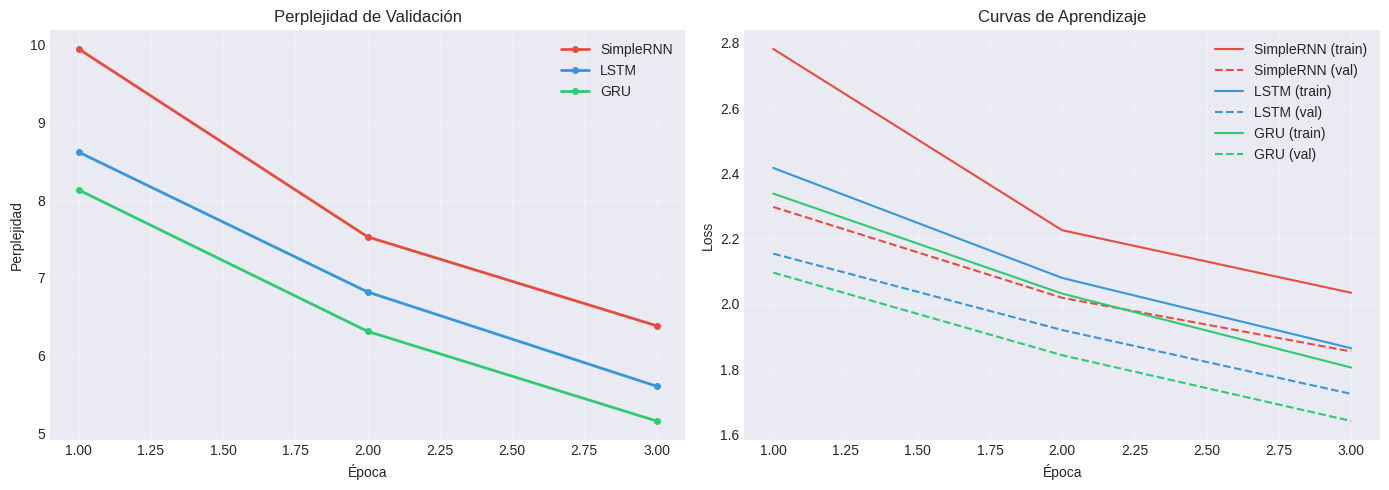


📊 Resumen de Modelos:
  SimpleRNN : PPL = 6.38
  LSTM      : PPL = 5.61
  GRU       : PPL = 5.16


In [23]:
# Graficar curvas de entrenamiento
colors = {'rnn': '#e74c3c', 'lstm': '#3498db', 'gru': '#2ecc71'}
labels_map = {'rnn': 'SimpleRNN', 'lstm': 'LSTM', 'gru': 'GRU'}

if histories:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for model_type, history in histories.items():
        val_ppl = [np.exp(loss) for loss in history.history['val_loss']]
        epochs = range(1, len(val_ppl) + 1)
        axes[0].plot(epochs, val_ppl, color=colors[model_type],
                     label=labels_map[model_type], linewidth=2, marker='o', markersize=4)
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Perplejidad')
    axes[0].set_title('Perplejidad de Validación')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    for model_type, history in histories.items():
        epochs = range(1, len(history.history['loss']) + 1)
        axes[1].plot(epochs, history.history['loss'], color=colors[model_type],
                     label=f"{labels_map[model_type]} (train)", linestyle='-')
        axes[1].plot(epochs, history.history['val_loss'], color=colors[model_type],
                     label=f"{labels_map[model_type]} (val)", linestyle='--')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Curvas de Aprendizaje')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n📊 Resumen de Modelos:")
    print("=" * 55)
    for model_type in histories.keys():
        best_ppl = np.exp(min(histories[model_type].history['val_loss']))
        print(f"  {labels_map[model_type]:<10}: PPL = {best_ppl:.2f}")
    print("=" * 55)

---
## 7. Generación de Secuencias

In [24]:
# Seleccionar mejor modelo
best_model_type = min(histories, key=lambda x: min(histories[x].history['val_loss']))
model = models[best_model_type]
best_ppl = np.exp(min(histories[best_model_type].history['val_loss']))
print(f"🏆 Usando modelo: {best_model_type.upper()} (PPL: {best_ppl:.2f})")

🏆 Usando modelo: GRU (PPL: 5.16)


In [26]:
def greedy_search(model, seed_text, max_length, num_chars):
    """Genera texto usando búsqueda voraz."""
    generated_text = seed_text.lower()
    for _ in range(num_chars):
        tokens = [char2idx.get(ch, 0) for ch in generated_text[-max_length:]]
        if len(tokens) < max_length:
            tokens = [0] * (max_length - len(tokens)) + tokens
        x = np.array([tokens], dtype=np.int32)
        logits = model.predict(x, verbose=0)
        next_char_idx = np.argmax(logits[0, -1, :])
        generated_text += idx2char[next_char_idx]
    return generated_text

In [27]:
def sample_with_temperature(model, seed_text, max_length, num_chars, temperature=1.0):
    """Genera texto usando muestreo con temperatura."""
    generated_text = seed_text.lower()
    for _ in range(num_chars):
        tokens = [char2idx.get(ch, 0) for ch in generated_text[-max_length:]]
        if len(tokens) < max_length:
            tokens = [0] * (max_length - len(tokens)) + tokens
        x = np.array([tokens], dtype=np.int32)
        logits = model.predict(x, verbose=0)
        logits_scaled = logits[0, -1, :] / temperature
        probs = tf.nn.softmax(logits_scaled).numpy()
        next_char_idx = np.random.choice(len(probs), p=probs)
        generated_text += idx2char[next_char_idx]
    return generated_text

In [28]:
def beam_search_deterministic(model, seed_text, max_length, num_chars, beam_width=5):
    """Genera texto usando beam search determinístico."""
    seed_text = seed_text.lower()
    beams = [(seed_text, 0.0)]
    for _ in range(num_chars):
        all_candidates = []
        for text, score in beams:
            tokens = [char2idx.get(ch, 0) for ch in text[-max_length:]]
            if len(tokens) < max_length:
                tokens = [0] * (max_length - len(tokens)) + tokens
            x = np.array([tokens], dtype=np.int32)
            logits = model.predict(x, verbose=0)
            log_probs = tf.nn.log_softmax(logits[0, -1, :]).numpy()
            top_indices = np.argsort(log_probs)[-beam_width:]
            for idx in top_indices:
                all_candidates.append((text + idx2char[idx], score + log_probs[idx]))
        all_candidates.sort(key=lambda x: x[1], reverse=True)
        beams = all_candidates[:beam_width]
    final_sequences = [(text, score / len(text)) for text, score in beams]
    final_sequences.sort(key=lambda x: x[1], reverse=True)
    return final_sequences[0][0], final_sequences

In [29]:
def beam_search_stochastic(model, seed_text, max_length, num_chars, beam_width=5, temperature=1.0):
    """Genera texto usando beam search estocástico."""
    seed_text = seed_text.lower()
    beams = [(seed_text, 0.0)]
    for _ in range(num_chars):
        all_candidates = []
        for text, score in beams:
            tokens = [char2idx.get(ch, 0) for ch in text[-max_length:]]
            if len(tokens) < max_length:
                tokens = [0] * (max_length - len(tokens)) + tokens
            x = np.array([tokens], dtype=np.int32)
            logits = model.predict(x, verbose=0)
            logits_scaled = logits[0, -1, :] / temperature
            probs = tf.nn.softmax(logits_scaled).numpy()
            log_probs = np.log(probs + 1e-10)
            sampled_indices = np.random.choice(len(probs), size=min(beam_width, len(probs)),
                                               replace=False, p=probs)
            for idx in sampled_indices:
                all_candidates.append((text + idx2char[idx], score + log_probs[idx]))
        all_candidates.sort(key=lambda x: x[1], reverse=True)
        beams = all_candidates[:beam_width]
    final_sequences = [(text, score / len(text)) for text, score in beams]
    final_sequences.sort(key=lambda x: x[1], reverse=True)
    return final_sequences[0][0], final_sequences

In [30]:
# Ejemplos de generación
seed = "ulises dijo"
print("="*70)
print(f"🔬 COMPARACIÓN DE MÉTODOS - Semilla: '{seed}'")
print("="*70)

print("\n📍 GREEDY:")
print(greedy_search(model, seed, MAX_CONTEXT_SIZE, 100))

print("\n🎲 SAMPLING (T=0.7):")
print(sample_with_temperature(model, seed, MAX_CONTEXT_SIZE, 100, 0.7))

print("\n📊 BEAM SEARCH (width=5):")
result, _ = beam_search_deterministic(model, seed, MAX_CONTEXT_SIZE, 100, 5)
print(result)

print("\n🎯 BEAM STOCHASTIC (width=5, T=0.7):")
result, _ = beam_search_stochastic(model, seed, MAX_CONTEXT_SIZE, 100, 5, 0.7)
print(result)

🔬 COMPARACIÓN DE MÉTODOS - Semilla: 'ulises dijo'

📍 GREEDY:
ulises dijo en la casa y la casa y la casa y la casa y la casa y la casa y la casa y la casa y la casa y la cas

🎲 SAMPLING (T=0.7):
ulises dijo se que le habita la suerte. que sus caras y algún palacio y la destaban de las cielos había su arta

📊 BEAM SEARCH (width=5):
ulises dijo; y la casa de las palabras: —¡habló de los pretendientes de los pretendientes de los pretendientes 

🎯 BEAM STOCHASTIC (width=5, T=0.7):
ulises dijo en el palacio y los pretendientes de los pretendientes de los pretendientes de los pretendientes y 


In [31]:
# Efecto de la temperatura
seed = "el héroe regresó"
print("="*70)
print(f"🌡️ EFECTO DE LA TEMPERATURA - Semilla: '{seed}'")
print("="*70)

for temp in [0.2, 0.5, 0.8, 1.0, 1.5]:
    print(f"\n🌡️ T = {temp}:")
    print(sample_with_temperature(model, seed, MAX_CONTEXT_SIZE, 80, temp))

🌡️ EFECTO DE LA TEMPERATURA - Semilla: 'el héroe regresó'

🌡️ T = 0.2:
el héroe regresó a la 
puerta en la palacia, y al para que en su palacio y la casa y la casa de 

🌡️ T = 0.5:
el héroe regresó con el arco 
con su para con su palacio y atras paba la pasa, para que fue esta

🌡️ T = 0.8:
el héroe regresó en les sobre contumbras y coma que 

cara y odiseo a 
tu padre al hacer que int

🌡️ T = 1.0:
el héroe regresó odiseo y aqueo de 
del tus 
ejadas, y que selamana. las cabazdos. llevamente fu

🌡️ T = 1.5:
el héroe regresó que cuándo úgidó
 vino y ngnusolentos, rugalos .
voludá, agió la cma pama por; 


In [32]:
# Guardar modelo
model.save('best_char_lm_keras.keras')
print("✅ Modelo guardado en 'best_char_lm_keras.keras'")

✅ Modelo guardado en 'best_char_lm_keras.keras'


---
## Fin del Desafío 3 (Versión Keras)

✅ **Objetivos cumplidos:**
1. Corpus seleccionado y preprocesado
2. Tokenización por caracteres implementada
3. Tres arquitecturas RNN evaluadas (SimpleRNN, LSTM, GRU)
4. Cuatro métodos de generación implementados